In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import utils

In [2]:
#'''
Res_1 = utils.RetrievalResults(prefix='../retrieval_outputs/no_bands_K_B_ret_7/test_')

#Res_2 = utils.RetrievalResults(prefix='../retrieval_outputs/no_bands_K_B_ret_7/test_')
Res_2 = utils.RetrievalResults(prefix='../retrieval_outputs/eq_band_K_B_ret_3/test_')
#Res_2 = utils.RetrievalResults(prefix='../retrieval_outputs/spot_K_B_ret_16/test_')

#Res_3 = utils.RetrievalResults(prefix='../retrieval_outputs/spot_K_B_ret_19/test_')
#Res_3 = utils.RetrievalResults(prefix='../retrieval_outputs/spot_K_B_ret_20/test_')
Res_3 = utils.RetrievalResults(prefix='../retrieval_outputs/spot_K_B_ret_23/test_')
#Res_3 = utils.RetrievalResults(prefix='../retrieval_outputs/spot_K_B_ret_26/test_')
#'''

'''
Res_1 = utils.RetrievalResults(prefix='../retrieval_outputs/no_bands_K_A_ret_2/test_')
Res_2 = utils.RetrievalResults(prefix='../retrieval_outputs/eq_band_K_A_ret_3/test_')

#Res_3 = utils.RetrievalResults(prefix='../retrieval_outputs/spot_K_A_ret_1/test_')
#Res_3 = utils.RetrievalResults(prefix='../retrieval_outputs/spot_K_A_ret_2/test_')
Res_3 = utils.RetrievalResults(prefix='../retrieval_outputs/spot_K_A_ret_3/test_')
#'''

_, flux_global, Rot_1     = Res_1.get_model_spec(is_local=False)
wave_local, flux_local, _ = Res_1.get_model_spec(is_local=True)
rv, CCF, CCF_SNR_1 = Res_1.get_CCF(
    wave_local, flux_local, flux_global, 
    subtract_global=True, 
    )

_, flux_global, Rot_2     = Res_2.get_model_spec(is_local=False)
wave_local, flux_local, _ = Res_2.get_model_spec(is_local=True)
rv, CCF, CCF_SNR_2 = Res_2.get_CCF(
    wave_local, flux_local, flux_global, 
    subtract_global=True, 
    )

_, flux_global, Rot_3     = Res_3.get_model_spec(is_local=False)
wave_local, flux_local, _ = Res_3.get_model_spec(is_local=True)
rv, CCF, CCF_SNR_3 = Res_3.get_CCF(
    wave_local, flux_local, flux_global, 
    subtract_global=True, 
    )

#*_, Rot_3_spot = Res_3.get_model_spec(is_local=False, m_set='K2166_spot')
#Res_3.add_patch_to_Rot(Rot_3, Rot_3_spot)
#*_, Rot_3_spot = Res_3.get_model_spec(is_local=False, m_set='K2166_band')
#Res_3.add_patch_to_Rot(Rot_3, Rot_3_spot)

  analysing data from ../retrieval_outputs/no_bands_K_B_ret_7/test_.txt
  analysing data from ../retrieval_outputs/eq_band_K_B_ret_3/test_.txt
  analysing data from ../retrieval_outputs/spot_K_B_ret_23/test_.txt


100%|██████████| 1201/1201 [00:05<00:00, 235.14it/s]


In [3]:
Res_2.compare_evidence(Res_1.ln_Z); print()
Res_3.compare_evidence(Res_2.ln_Z); print()

Current vs. given: ln(B)=2789.37 | sigma=inf
Given vs. current: ln(B)=-2789.37 | sigma=nan

Current vs. given: ln(B)=26.46 | sigma=7.57
Given vs. current: ln(B)=-26.46 | sigma=nan



/home/sam/Documents/PhD/CRIRES_data_reduction/retrieval_base/Luhman_16/figures/utils.py:108: RuntimeWarning: overflow encountered in exp
  B = np.exp(ln_B)
/home/sam/Documents/PhD/CRIRES_data_reduction/retrieval_base/Luhman_16/figures/utils.py:114: RuntimeWarning: divide by zero encountered in scalar divide
  _p = np.real(np.exp(W((-1.0/(_B*np.exp(1))),-1)))


24.064500194915613 19.703892135639272 -1.838549876034044
25.09835182627515 19.639855950580337 -1.774513690975109
25.2758765223578 19.715945751205066 -1.8506034915998377


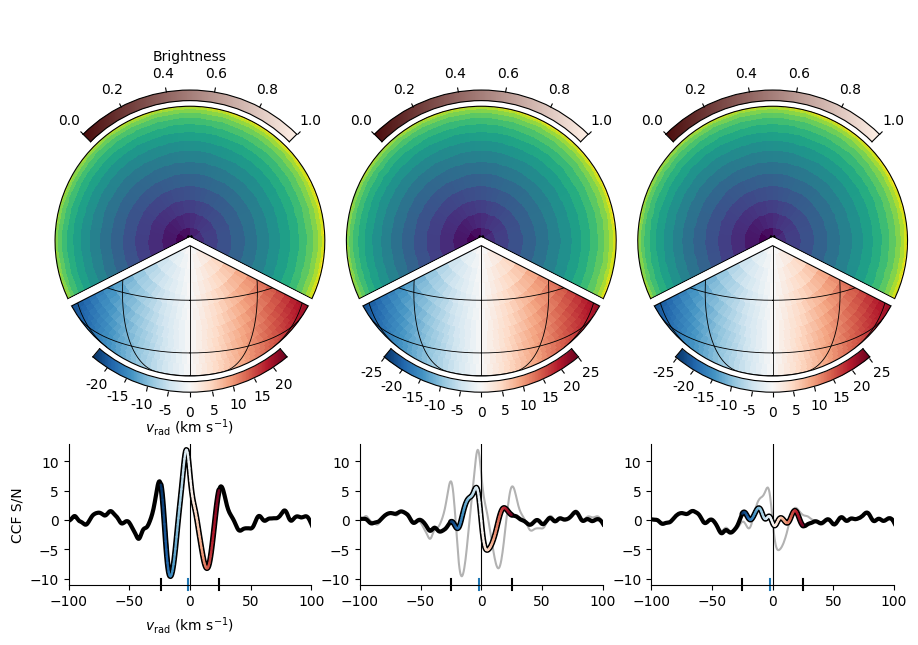

In [4]:
shrink = 0.9
cmap = utils.get_cmap()

old_CCF_i = None

ax_thetalim  = [
    np.pi/2 + 1/2*1.3*np.pi*np.array([-1,1]), 
    -np.pi/2 + 1/2*(2-1.3)*np.pi*np.array([-1,1])
    #-np.pi/2 + 1*np.pi*np.array([-1,1]), 
    #np.pi/2*np.array([1,1])
    ]
cax_thetalim = [
    (np.pi/2-np.pi/4,np.pi/2+np.pi/4), 
    #(-np.pi+1/4*np.pi,-np.pi+3/4*np.pi), 
    (-np.pi/2-np.pi/4.5,-np.pi/2+np.pi/4.5), 
    ]

fig = plt.figure(figsize=(11,6.5))
gs = fig.add_gridspec(nrows=2, ncols=3, hspace=0.2, wspace=0.08, height_ratios=[1,0.45])

ax = []; cax = []; ax_CCF = []

iterables = zip(
    [Rot_1, Rot_2, Rot_3], [Res_1, Res_2, Res_3], 
    [CCF_SNR_1, CCF_SNR_2, CCF_SNR_3]
    )
for i, (Rot_i, Res_i, CCF_i) in enumerate(iterables):

    vsini_i = Res_i.bestfit_params['K2166_cloudy']['vsini']
    rv_i    = Res_i.bestfit_params['K2166_cloudy']['rv']
    vtell_i = Res_i.vtell
    print(vsini_i, rv_i, vtell_i)

    # --- Brightness map --------------------------------
    ax_i  = fig.add_subplot(gs[0,i], projection='polar')
    cax_i = fig.add_subplot(gs[0,i], projection='polar')

    labels = ['Brightness', r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$']
    if i != 0:
        labels = [None, None]

    sphere = utils.SpherePlot(Rot_i, fig, ax_i, cax_i)
    sphere.plot_map(
        attr='int_flux', cmap=cmap, edgecolors='face', lw=1e-6, 
        )
    sphere.configure_ax(
        xlim=ax_thetalim[0], sep_spine_lw=5, grid_lw=0.6, grid_color='none'
        )
    sphere.configure_cax(
        label=labels[0], xlim=cax_thetalim[0], cb_width=0.07, scale=1.12, flip_cb=False, 
        xticks=[0.0,0.2,0.4,0.6,0.8,1.0], vmin=1., vmax=0., cmap=cmap
        #xticks=[1.0,0.8,0.6,0.4,0.2,0.0], vmin=0., vmax=1., cmap=cmap
        )
    ax.append(ax_i); cax.append(cax_i)
    
    # --- Velocity map ----------------------------------
    ax_i  = fig.add_subplot(gs[0,i], projection='polar')
    cax_i = fig.add_subplot(gs[0,i], projection='polar')
    sphere = utils.SpherePlot(Rot_i, fig, ax_i, cax_i)
    sphere.plot_map(
        attr='v_grid', cmap='RdBu_r', edgecolors='face', lw=1e-6, 
        )
    sphere.configure_ax(
        xlim=ax_thetalim[1], sep_spine_lw=5, grid_lw=0.6
        )
    sphere.configure_cax(
        label=labels[1], 
        xlim=cax_thetalim[1], cb_width=0.07, scale=1.12, 
        xticks=np.arange(-25,25+1,5), vmin=-vsini_i, vmax=vsini_i, cmap='RdBu_r'
        )
    ax.append(ax_i); cax.append(cax_i)

    # --- Cross-correlation -----------------------------
    ax_CCF_i = fig.add_subplot(gs[1,i])

    ylabel = None
    if i == 0:
        ylabel = 'CCF S/N'
    CC = utils.CrossCorrPlot(fig, ax_CCF_i, vsini=vsini_i, vtell=vtell_i)
    #CC.plot(rv, CCF_i, old_CCF_i, lw=3, c='k', plot_colorbar=False)
    CC.plot(rv, CCF_i, old_CCF_i, lw=3, c='k', plot_colorbar=False)
    #CC.plot(np.abs(rv), CCF_i, old_CCF_i, lw=3, c='k', plot_colorbar=False)
    CC.configure_ax(
        xlabel=labels[1], ylabel=ylabel, ylim=(-11,13), xlim=(-100,100)
        )
    CC.add_xtick_at_vsini(color='k')
    CC.add_xtick_at_vtell(length=0.08, color='C0', )#lw=0.8, )

    # Shrink the CCF axis
    l, b, w, h = ax_CCF_i.get_position().bounds
    ax_CCF_i.set_position([l + (1-shrink)*w/2, b, w*shrink, h])

    old_CCF_i = CCF_i.copy()

    ax_CCF.append(ax_CCF_i)

# Create a tighter bounding box to save the figure
l, b, *_ = ax_CCF[0].get_position().bounds
r = ax_CCF[-1].get_position().bounds[0] + ax_CCF[-1].get_position().bounds[2]
t = cax[0].get_position().bounds[1] + cax[0].get_position().bounds[3]

#l, r, b, t = np.array([l, r, b, t]) + np.array([-0.055,0.02,-0.07,-0.05])
l, r, b, t = np.array([l, r, b, t]) + np.array([-0.06,0.02,-0.08,-0.045])

l, r = np.array([l, r]) * fig.get_size_inches()[0]
b, t = np.array([b, t]) * fig.get_size_inches()[1]
bbox = mpl.transforms.Bbox([[l,b],[r,t]])

plt.savefig('./plots/surface_comparison_B.pdf', bbox_inches=bbox)
#plt.savefig('./plots/surface_comparison_A.pdf', bbox_inches=bbox)
plt.show()

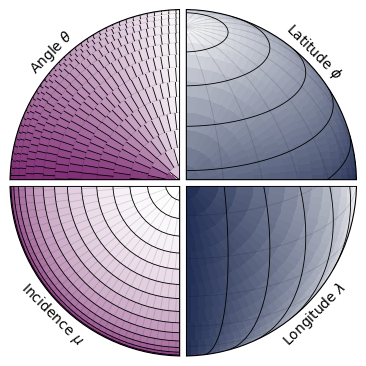

In [78]:
fig = plt.figure(figsize=(4.5,4.5))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0., wspace=0.)

ax = []
attr  = ['lon_grid', 'mu_grid', 'theta_grid', 'lat_grid']
xlims = [
    #(3/4*np.pi, np.pi), (1/2*np.pi, 3/4*np.pi), (1/4*np.pi, 1/2*np.pi), (0, 1/4*np.pi)
    (3/2*np.pi, 2*np.pi), (np.pi, 3/2*np.pi), (1/2*np.pi, np.pi), (0, 1/2*np.pi)
]
vmin_vmax = [
    (0,np.pi/2), (0,1), (3/2*np.pi,2*np.pi), (0,np.pi/2),
]
cmaps = [
    utils.get_cmap(['#1E2B51', '#FFDDC3']), 
    utils.get_cmap(['#7D2872', '#FFDDC3']), 
    utils.get_cmap(['#7D2872', '#FFDDC3']), 
    utils.get_cmap(['#1E2B51', '#FFDDC3']), 
    ]
cmaps = [
    utils.get_cmap(['#1E2B51', 'w']), 
    utils.get_cmap(['#7D2872', 'w']), 
    utils.get_cmap(['#7D2872', 'w']), 
    utils.get_cmap(['#1E2B51', 'w']), 
    ]
labels = [
    r'$\mathrm{Longitude}\ \lambda$', 
    r'$\mathrm{Incidence}\ \mu$', 
    r'$\mathrm{Angle}\ \theta$', 
    r'$\mathrm{Latitude}\ \phi$', 
]

for i, attr_i in enumerate(attr):

    ax_i = fig.add_subplot(gs[0,0], projection='polar')

    attr_i = attr[i]

    theta_grid_kwargs, r_grid_kwargs = None, None
    latlon_grid_kwargs = dict(lw=0.6, c='k')

    # Plot the radial/angular grid only
    if attr_i == 'mu_grid':
        theta_grid_kwargs = dict(lw=0.6, c='k', alpha=0.13)
        r_grid_kwargs     = dict(lw=0.6, c='k')
    if attr_i == 'theta_grid':
        theta_grid_kwargs = dict(lw=0.6, c='k')
        r_grid_kwargs     = dict(lw=0.6, c='k', alpha=0.13)

    Rot_i.inc = np.deg2rad(26)
    Rot_i.get_latlon()

    sphere = utils.SpherePlot(Rot_i, fig, ax_i, cax=None)
    sphere.plot_map(
        attr=attr_i, cmap=cmaps[i], vmin=vmin_vmax[i][0], vmax=vmin_vmax[i][1], 
        theta_grid_kwargs=theta_grid_kwargs, r_grid_kwargs=r_grid_kwargs, 
        edgecolors='face', lw=1e-6, zorder=2
        )
    sphere.configure_ax(
        xlim=xlims[i], sep_spine_lw=4, plot_grid=False, # **grid_kwargs_2
        )
    
    # Plot the latitude/longitude grid only
    if attr_i == 'lat_grid':
        sphere.grid(
            lon_grid=[0], lat_grid=np.arange(-90, 90+1e-6, 15), 
            inc=np.rad2deg(sphere.Rot.inc), **latlon_grid_kwargs
            )
        sphere.grid(
            lat_grid=[90], lon_grid=np.arange(-180, 180+1e-6, 15), 
            inc=np.rad2deg(sphere.Rot.inc), alpha=0.13, **latlon_grid_kwargs
            )
    if attr_i == 'lon_grid':
        sphere.grid(
            lat_grid=[90], lon_grid=np.arange(-180, 180+1e-6, 15), 
            inc=np.rad2deg(sphere.Rot.inc), **latlon_grid_kwargs
            )
        sphere.grid(
            lon_grid=[0], lat_grid=np.arange(-90, 90+1e-6, 15), 
            inc=np.rad2deg(sphere.Rot.inc), alpha=0.13, **latlon_grid_kwargs
            )
        
    # Add a label to this quadrant
    xy = (np.mean(xlims[i]),1.07)
    rotation = np.rad2deg(xy[0])
    if rotation > 180:
        rotation -= 180
    rotation -= 90

    ax_i.annotate(
        labels[i], xy=xy, xycoords='data', annotation_clip=False, 
        ha='center', va='center', rotation=rotation
        )

    ax.append(ax_i)

pad = 0.02

# Create a tighter bounding box to save the figure
bounds = np.array([
    list(ax_i.get_position().bounds) for ax_i in ax
    ])

l = np.min(bounds[:,0])
b = np.min(bounds[:,1])
r = np.max(bounds[:,0]) + bounds[np.argmax(bounds[:,0]),2]
t = np.max(bounds[:,1]) + bounds[np.argmax(bounds[:,1]),3]

l -= pad
b -= pad
r += pad
t += pad

l, r = np.array([l, r]) * fig.get_size_inches()[0]
b, t = np.array([b, t]) * fig.get_size_inches()[1]
bbox = mpl.transforms.Bbox([[l,b],[r,t]])

#plt.savefig('./plots/grid_definition.png', bbox_inches=bbox, dpi=100)
plt.savefig('./plots/grid_definition.pdf', bbox_inches=bbox)
plt.show()